In [1]:
import torch, datasets, transformers
import numpy as np
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [2]:
from sklearn.neighbors import NearestNeighbors
from icecream import ic
ic.configureOutput(outputFunction=print)
feature_dict = np.load(
    "../vqav2/clip_feature_for_knn.pkl", allow_pickle=True
)
ic(feature_dict.keys())
ic(feature_dict["feature"].shape)

ic| feature_dict.keys(): dict_keys(['image_id', 'feature'])
ic| feature_dict["feature"].shape: (204721, 768)


(204721, 768)

In [3]:
# reverse feature_dict["image_id"] to iid2idx dict
logging.info("Reverse Image ID to Index")
iid2idx = {v: k for k, v in enumerate(feature_dict["image_id"])}

# Compute similar images **only for train images**
logging.info("Calculating NN Estimator...")
nns = NearestNeighbors(n_neighbors=5)
nns.fit(feature_dict["feature"])

NearestNeighbors()

In [4]:
from glob import glob
import os

def getiid_from_path(image_path):
    filename = os.path.basename(image_path)
    image_id = filename.split("_")[-1]
    image_id, _ = image_id.split(".")
    return int(image_id)

class IIDRetriever(object):
    def __init__(self, paths = [
        "~/data/vqav2/img/test/test2015/*.jpg",
        "~/data/vqav2/img/val/val2014/*.jpg",
        "~/data/vqav2/img/train/train2014/*.jpg",
    ]):
        paths = map(os.path.expanduser, paths)
        full_paths = sum([glob(p) for p in paths], [])
        full_path2iid = {
            p: getiid_from_path(p) for p in full_paths
        }
        iid2full_paths = {
            v: k for k, v in full_path2iid.items()
        }
        # ic(full_paths[:10])
        self.iid2full_paths = iid2full_paths
        self.full_path2iid = full_path2iid
    
    def retrive_image_from_iid(self, iid):
        return self.iid2full_paths[iid]

In [5]:
retriever = IIDRetriever()
ic(len(feature_dict["image_id"]))
for i in range(130_000, 200_001, 10_000):
    ic(i, feature_dict["image_id"][i], retriever.retrive_image_from_iid(feature_dict["image_id"][i]))

ic| len(feature_dict["image_id"]): 204721
ic| i: 130000
    feature_dict["image_id"][i]: 56695
    retriever.retrive_image_from_iid(feature_dict["image_id"][i]): '/home/yangliu/data/vqav2/img/train/train2014/COCO_train2014_000000056695.jpg'
ic| i: 140000
    feature_dict["image_id"][i]: 126537
    retriever.retrive_image_from_iid(feature_dict["image_id"][i]): '/home/yangliu/data/vqav2/img/train/train2014/COCO_train2014_000000126537.jpg'
ic| i: 150000
    feature_dict["image_id"][i]: 197570
    retriever.retrive_image_from_iid(feature_dict["image_id"][i]): '/home/yangliu/data/vqav2/img/train/train2014/COCO_train2014_000000197570.jpg'
ic| i: 160000
    feature_dict["image_id"][i]: 268510
    retriever.retrive_image_from_iid(feature_dict["image_id"][i]): '/home/yangliu/data/vqav2/img/train/train2014/COCO_train2014_000000268510.jpg'
ic| i: 170000
    feature_dict["image_id"][i]: 337748
    retriever.retrive_image_from_iid(feature_dict["image_id"][i]): '/home/yangliu/data/vqav2/img/train/tr

In [6]:
selected_idxs = list(range(140_000, 200_001, 10_000))

In [7]:
# retreive similar images for selected_idxs
logging.info("Retreiving similar images...")
selected_iids = [feature_dict["image_id"][i] for i in selected_idxs]
ic(selected_iids)
similar_idxs = nns.kneighbors(
    feature_dict["feature"][selected_idxs],
    return_distance=False,
    n_neighbors=4+1
)[:, 0:] 
# => [N, K]
ic(similar_idxs.shape, similar_idxs)
# get similar images from similar_idxs
similar_images_iid = [
    [feature_dict["image_id"][idx] for idx in idxs] for idxs in similar_idxs
]
ic(similar_images_iid)
# Retrieve image path for similar_images_iid
similar_images_path = [
    [retriever.retrive_image_from_iid(iid) for iid in iids] for iids in similar_images_iid
]
ic(similar_images_path[0])



ic| selected_iids: [126537, 197570, 268510, 337748, 407334, 478105, 549287]
ic| similar_idxs.shape: (7, 5)
    similar_idxs: array([[140000, 174229,  17742,  41524,  58141],
                         [150000,  46177, 160498,  89198, 179153],
                         [160000, 187656, 177764, 100306,  42490],
                         [170000,  99199,  88374, 194203,   8593],
                         [180000,  43425,  71945, 107843,  71163],
                         [190000, 112690,  89866,  93313, 100868],
                         [200000, 199940,  86894, 138828,  90739]])
ic| similar_images_iid: [[126537, 367111, 127487, 296054, 415161],
                         [197570, 329871, 272022, 112085, 401625],
                         [268510, 461558, 392154, 271206, 302988],
                         [337748, 254750, 99747, 507904, 61691],
                         [407334, 309709, 514774, 378723, 509184],
                         [478105, 449279, 121677, 170411, 279305],
                       

['/home/yangliu/data/vqav2/img/train/train2014/COCO_train2014_000000126537.jpg',
 '/home/yangliu/data/vqav2/img/train/train2014/COCO_train2014_000000367111.jpg',
 '/home/yangliu/data/vqav2/img/test/test2015/COCO_test2015_000000127487.jpg',
 '/home/yangliu/data/vqav2/img/test/test2015/COCO_test2015_000000296054.jpg',
 '/home/yangliu/data/vqav2/img/test/test2015/COCO_test2015_000000415161.jpg']

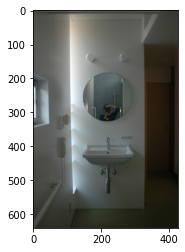

In [8]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
similar_images = [
    [mpimg.imread(p) for p in paths] for paths in similar_images_path
]
plt.figure()
plt.imshow(similar_images[2][3])
plt.show()


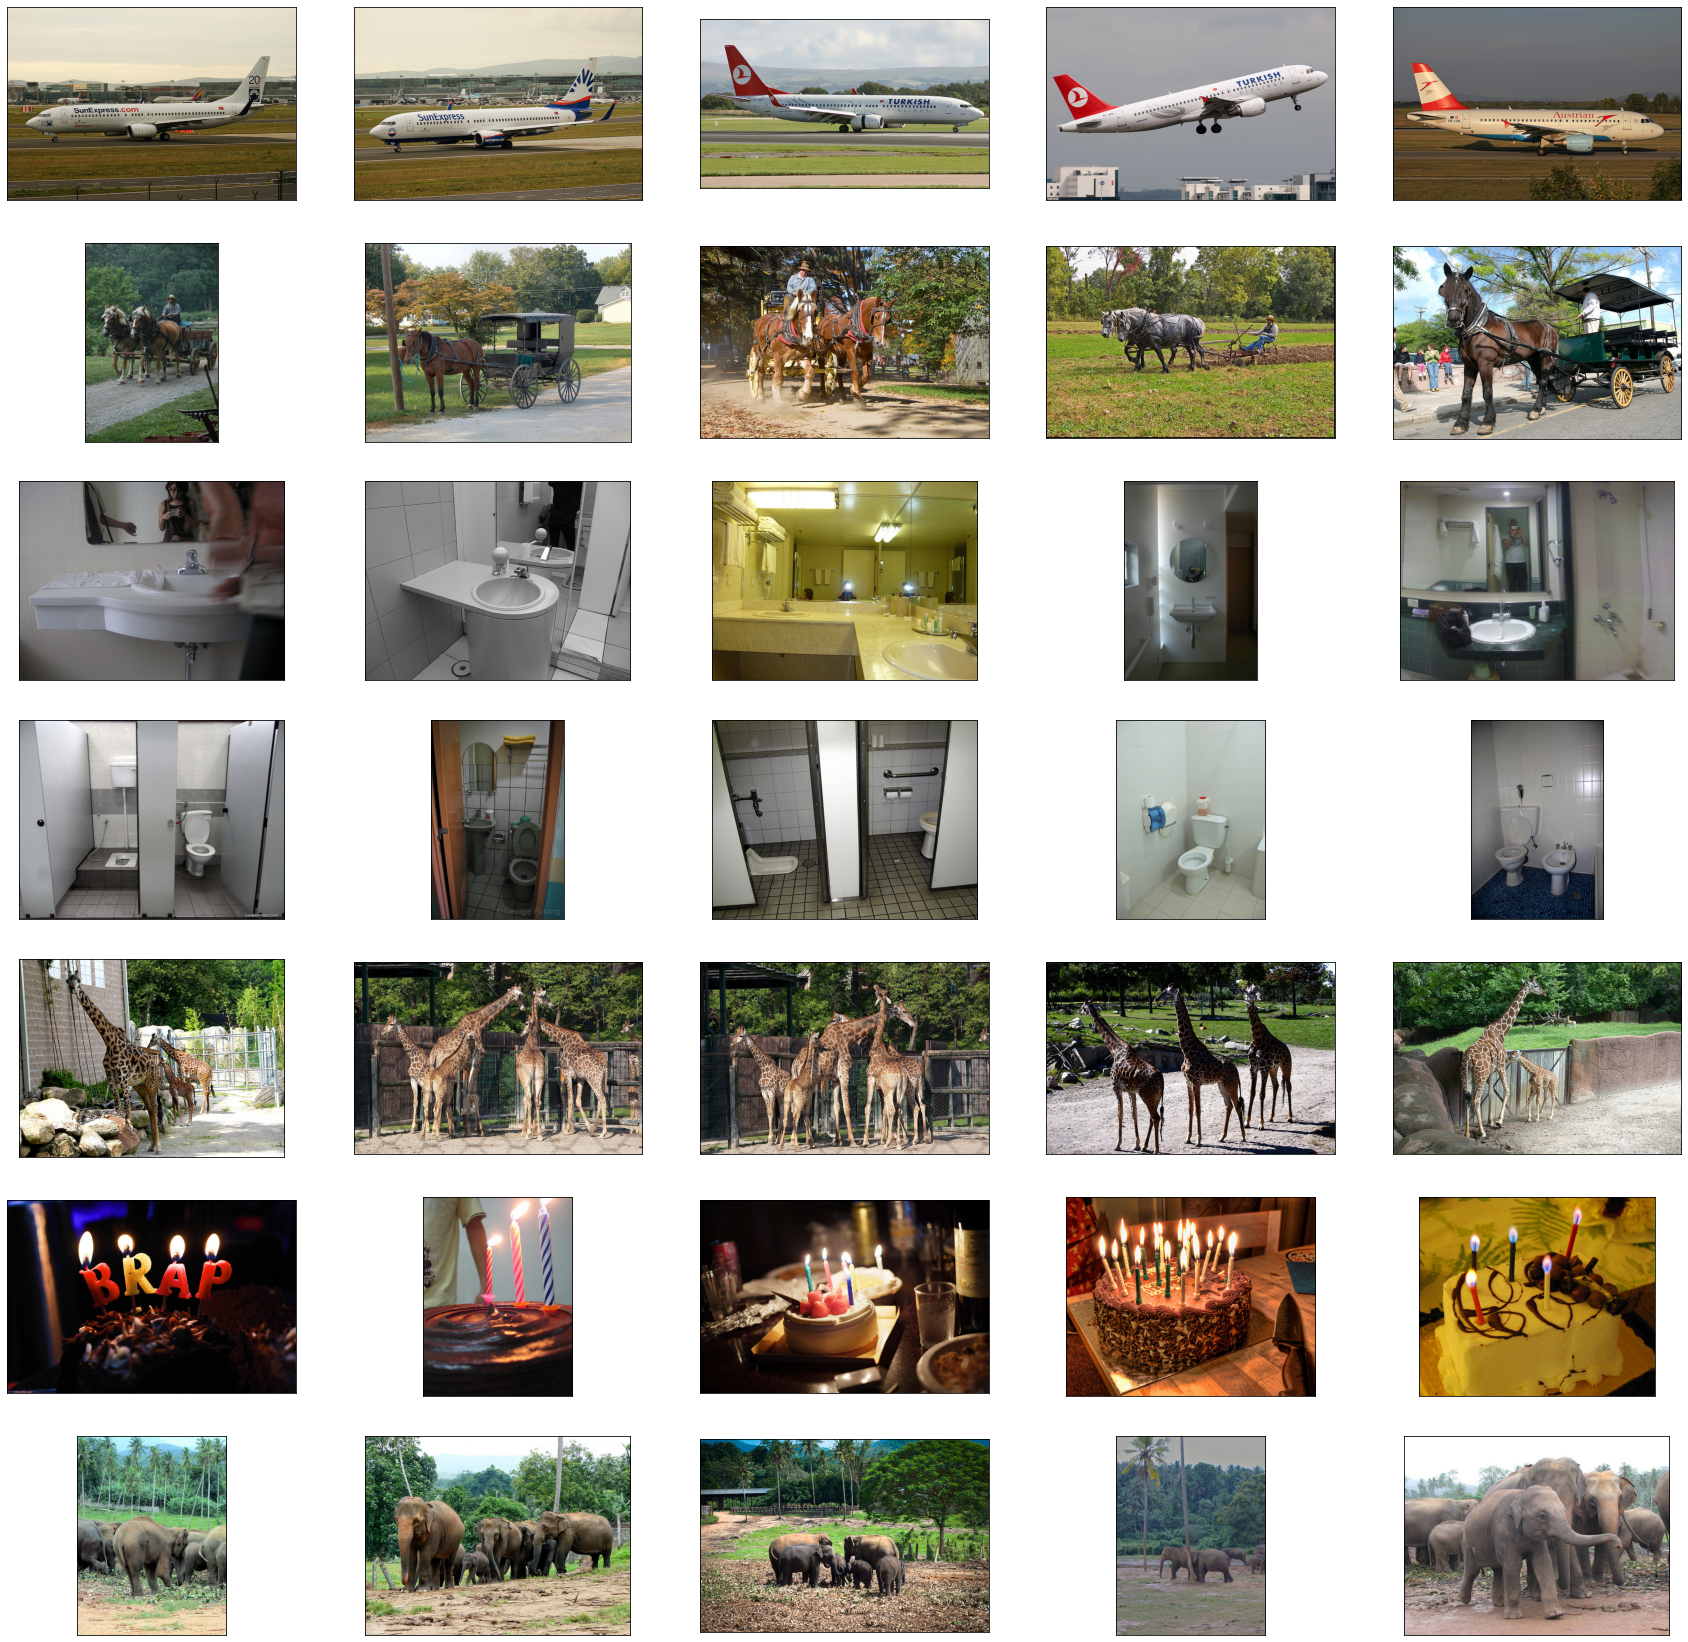

In [11]:
plt.figure(figsize=(30, 30))
n_images = len(similar_images)
n_neighbors = len(similar_images[0])
for i in range(0, n_images):
    for j in range(n_neighbors):
        plt.subplot(n_images, n_neighbors, i*n_neighbors+j+1)
        plt.imshow(similar_images[i][j])    
        # Hide ticks
        plt.tick_params(
            axis="both",
            which="both",
            bottom=False,
            top=False,
            labelbottom=False,
            left=False,
            right=False,
            labelleft=False,
        )

# Plot caption



plt.show()

In [12]:
plt.savefig("similar_images_visual.png", dpi=500)

<Figure size 432x288 with 0 Axes>